In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Ｇrayscale(num_output_channels=1)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=12,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=12,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Grayscale(num_output_channels=1)
           )

In [5]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Grayscale(num_output_channels=1)
           )

In [6]:
classes = ['plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

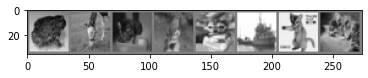

 frog horse   dog  bird   dog  ship   cat   cat


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join("%5s" % classes[labels[i]] for i in range(8)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = self._make_layers([64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'])
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        # print('channels =', in_channels)
        return nn.Sequential(*layers)

In [9]:
vgg11 = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)
vgg11 = vgg11.to(device)

In [11]:
running_loss = 0.0
for i, data in enumerate(trainloader):
    # get the inputs; data is a list of [inputs, labels]
    # shape of `inputs`: (12, 1, 28, 28)
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # print(inputs)
    # print(inputs.shape)

    # zero the parameter gradients
    optimizer.zero_grad()
    # print(inputs)

    # forward + backward + optimize
    outputs = vgg11(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if (i + 1) % 100 == 0:    # print every 100 mini-batches
        print('With %d batches, loss: %.3f' %
                (i + 1, running_loss / 100))
        running_loss = 0.0
    if i == 1000:
        break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


With 100 batches, loss: 2.275
With 200 batches, loss: 2.090
With 300 batches, loss: 1.908
With 400 batches, loss: 1.870
With 500 batches, loss: 1.765
With 600 batches, loss: 1.738
With 700 batches, loss: 1.709
With 800 batches, loss: 1.690
With 900 batches, loss: 1.641
With 1000 batches, loss: 1.549


In [12]:
PATH = './mnist_vgg11.pth'
torch.save(vgg11.state_dict(), PATH)

In [13]:
vgg11 = Net()
vgg11.load_state_dict(torch.load(PATH))

if torch.cuda.is_available():
    vgg11.cuda()

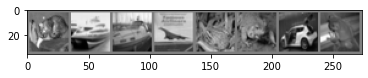

GroundTruth:  cat ship ship plane frog frog car frog
Predicted:    cat plane cat plane frog frog plane cat


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images, labels = images[:8], labels[:8]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%3s' % classes[labels[i]] for i in range(8)))

images = images.to(device)
outputs = vgg11(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%3s' % classes[predicted[i]] for i in range(8)))

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %
